In [1]:
"""Data gathering module.

The sets of functions here help to gather the data from the source.

Authors: 
"""

import re
import numpy as np
import pandas as pd

def cut(c):
    """Cut the data by a patron defined and return a tuple.

    Keyword arguments:
    data -- the data to cut, list
    
    """
    flag = True
    data = []
    head = []
    patron = re.compile("\s+")
    for i in c:
        if flag == True:
            head.append(patron.split(i))
            flag = False
        else:
            data.append(patron.split(i))
    return np.array(data),head

def parser(data):
    """Transform data from source txt to an structure and return a pd.DataFrame.

    Keyword arguments:
    data -- the data to transform, list
    
    """
    c = []
    alpha = []
    gamma = []
    flag = 0
    flag1 = False
    for i in range(len(data)):
        flag1= re.findall("\# ######### LIGHT ",data[i])
        if flag1:
            data= data[i+1:]
            break
    for i in range(len(data)):
        head = re.findall("\A#\s+(.+)",data[i])
        new_line = re.findall("\A   (.+)",data[i]) 
        ra = re.findall("\#ra=\s+(.+)",data[i])
        dec = re.findall("\#dec=\s+(.+)",data[i])

        if ra:
            ra_aux = ra
        if dec:
            dec_aux = dec
        if head:
            [c.append(j) for j in head]
        if new_line:
            [c.append(k) for k in new_line]
            alpha.append(ra_aux)
            gamma.append(dec_aux)
            try:
                next_line = re.findall("\A   (.+)",data[i+1])
                if not next_line:
                    reg, col= cut(c)
                    if flag == 0:
                        df = pd.DataFrame(reg,columns=col)
                        df["RA"] = np.array(alpha)
                        df["DEC"] = np.array(gamma)
                        c = []
                        alpha = []
                        gamma = []
                        flag += 1                    
                    else:
                        df_aux = pd.DataFrame(reg,columns=col)
                        df_aux["RA"] = np.array(alpha)
                        df_aux["DEC"] = np.array(gamma)
                        df = pd.concat([df,df_aux],ignore_index=True)
                        c = []
                        alpha = []
                        gamma = []

            except:
                reg, col = cut(c)
                if flag == 0:
                    df = pd.DataFrame(reg,columns=col)
                    df["RA"] = np.array(alpha)
                    df["DEC"] = np.array(gamma)
                    c = []
                    alpha = []
                    gamma = []
                    flag += 1   
                else:    
                    df_aux = pd.DataFrame(reg,columns=col)
                    df_aux["RA"] = np.array(alpha)
                    df_aux["DEC"] = np.array(gamma)
                    df = pd.concat([df,df_aux],ignore_index=True)

    col[0].remove('GRADE')
    df[col[0]] = df[col[0]].astype(float)

    return df

In [2]:
"""Preprocessing module.

The sets of functions here help from the perspective of preprocessing, complementing
the module of data gathering and features extraction.

Authors: 
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
        
def outliers_iqr(ys):
    """Delete atypical data.

    Keyword argument:
    ys -- the data, np.narray
    
    """
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr*1.5)
    upper_bound = quartile_3 + (iqr*1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))
        
def high_photometric_errors(data):
    """Delete high photometric errors and return a np.narray.

    Keyword argument:
    data -- the data to analyze, np.narray
    
    """
    mer_mean = np.mean(data)
    mer_std = np.std(data)
    error_limit = mer_mean + 3*mer_std
    return np.where((data >= error_limit))

# funcion que hace todo el preprocesamiento
def preprocessing(data,aperture):
    """Preprocess data for an aperture and return a tuple.

    Keyword arguments:
    data -- the data to analyze, pd.DataFrame
    aperture -- the aperture index, str
    
    """
    # 1 - se eliminan las mediciones con alto error fotometrico
    hpe_index = high_photometric_errors(data["MER_"+aperture].values)
    data = data.drop(data.index[hpe_index[0]])
    #2 - se eliminan datos atípicos
    outliers_index = outliers_iqr(data["MAG_"+aperture].values)
    data = data.drop(data.index[outliers_index[0]])
    # Se retornan los dias julianos y la magnitud de la apertura seleccionada
    return data["HJD"].values.ravel(),data["MAG_"+aperture].values.ravel()

def grade_filter(df,grades,mags):
    """Filter the data to preprocess and return a tuple.

    Keyword arguments:
    df -- the data to analyze, pd.DataFrame
    grades -- the grades to analyze, list
    mags -- the magnitudes to analyze, tuple
    
    """
    mask = df['GRADE'].isin(grades).all(1)
    res = df[mask]
    #for i in mags:
    #    if (int(i)!=0):
    #        data = preprocessing(res,i)
    return data

def Sort(tup):
    """Sort a tuple in descending order and return a tuple.

    Keyword arguments:
    tup -- tuple to sort, tuple
    
    """
    # reverse = True (Sorts in Descending order)
    return(sorted(tup, key = lambda x: float(x[0]), reverse = True))
        
def graph(data,path,title):
    """Graph in a scatter type and save to a folder.

    Keyword arguments:
    data -- the data to graph, tuple
    path -- the path to save, str
    title -- the graph title, str
    
    """
    data = Sort(data)
    fig, ax = plt.subplots()
    ax.scatter(data[0],data[1])
    ax.set(xlabel='HJD', ylabel='Magnitude',
           title=title)
    ax.grid()
    fig.savefig(path+"/"+title+"_fig.png")


In [3]:
"""Features extraction module.

The objective of this module is analyze the preprocessed light curves.

Authors: 
"""

from scipy.optimize import curve_fit
import numpy as np
import pandas as pd

def lineal_fit(t,a,b):
    """Lineal fit to data and return param m np.narray.

    Keyword arguments:
    t -- A np.narray
    a -- A float
    b -- A float
    
    """
    m = a+b*t
    return m

def parabolic_fit(t,a,b,c):
    """Parabolic fit to data and return param m np.narray.

    Keyword arguments:
    t -- A np.narray
    a -- A float
    b -- A float
    c -- A float
    
    """
    m = a + b*t + c*t*t
    return m

# Por ahora fit puede ser lineal o parabolico
def get_statistics(t,y):
    """Obtain and return Q1', C1, Q2' and C2.

    Keyword arguments:
    t -- A np.narray
    y -- A np.narray

    """
    # Desviacion estandar y
    dep = np.std(y)
    #para fit lineal
    poptl, pcovl = curve_fit(lineal_fit, t, y)
    y_hatl = lineal_fit(t,*poptl)
    perrl = np.sqrt(np.diag(pcovl))
    defl = np.sqrt(np.sum((y_hatl- y)*(y_hatl- y))/len(y))
    q1 = poptl[1]/perrl[1]
    c1 = 1-(defl/dep)
    # Para fit parabolico
    poptp, pcovp = curve_fit(parabolic_fit, t, y)
    y_hatp = parabolic_fit(t,*poptp)
    perrp = np.sqrt(np.diag(pcovp))
    defp = np.sqrt(np.sum((y_hatp- y)*(y_hatp- y))/len(y))
    q2 = poptp[2]/perrp[2]
    c2 = 1-(defp/defl)
    stat = [q1,c1,q2,c2]
    return stat

def get_ra_dec(data):
    """Obtain and return RA and DEC, both str.
    
    RA is the Right Ascencion.
    DEC is the Declination.

    Keyword arguments:
    data -- the data to analyze, pd.DataFrame
    
    """
    ra= data.iloc[0]["RA"].values[0]
    ra= ra.split(" ")
    dec= data.iloc[0]["DEC"].values[0]
    dec= dec.split(" ")
    return ra[0],dec[0]


In [4]:
"""Classification module.

The objective of this module is to classify each star by his light curve's
params obtained from features extraction module, filtering by a group of 
thresholds the stars that are not periodic large variable.

Authors: 
"""

import pandas as pd
import numpy as np
import os

def grades():
    """Ask for grades to keyboard input and return a list with the keyboard input."""
    try:
        grades = input('Select GRADE, usage "A,B,..." with valid options A,B,C,D: ')
        if not(set(grades.split(",")) <= {'A','B','C','D'}):
            raise ValueError(grades)
        return grades.split(",")
    except ValueError:
        print("incorrect GRADE, ingressed: ",grades)
        raise
        
def mags():
    """Ask for magnitudes to keyboard input and return a tuple."""
    try:
        mags = input('Select MAG, usage MAG_2,MAG_0,MAG_1,MAG_3,MAG_4 like 0,0,1,0,0 for only MAG_1 with full weight: ')
        if (int(max(set(mags.split(",")))) > 1):
            raise ValueError(mags)
        return tuple(mags.split(","))
    except ValueError:
        print("incorrect MAG, ingressed: ",mags)
        raise
        
def stars_filter(data, ThreshQ1, ThreshC1, ThreshQ2, ThreshC2):
    """Filter the data by thresholds and return the filtered data as pd.DataFrame.

    Keyword arguments:
    data -- the data to analyze, pd.DataFrame
    ThreshQ1 -- the threshold for Q1
    ThreshC1 -- the threshold for C1
    ThreshQ2 -- the threshold for Q2
    ThreshC2 -- the threshold for C2
    """
    return data[(data['Q1']>=ThreshQ1)&(data['C1']>ThreshC1)&(data['Q2']>=ThreshQ2)&(data['C2']>ThreshC2)]

###########################Example function - blue box#############################
# usage: 
# path = directory path with data
# ThreshQ1, ThreshC1, ThreshQ2, ThreshC2 are the threshold used in final stage
# optional: when "stop" archives were opened -> stop, if 0 open all archives in path
def blue_box(path,ThreshQ1, ThreshC1, ThreshQ2, ThreshC2,stop=0):
    "Doc"
    grad = grades()
    mag = mags()
    counter = 0
    row= []
    col= ["ASAS NAME","RA","DEC","Q1","C1","Q2","C2"]
    
    for filename in os.listdir(path):
        file = open(path+filename,"r")
        text = file.readlines()
        df = parser(text)
        file.close()
        res = grade_filter(df,grad,mag)
        counter+=1
        #graph(res,"test",filename)
        stats = get_statistics(res[0],res[1])
        ra,dec= get_ra_dec(df)
        row.append([filename,ra,dec,stats[0],stats[1],stats[2],stats[3]])
        
        if ((stop>0)&(stop==counter)):
            break
    data = pd.DataFrame(row,columns=col)
    data = stars_filter(data, ThreshQ1, ThreshC1, ThreshQ2, ThreshC2)
    return data

####################################################################################


In [5]:
file = open("data/170000-2407.3.lc","r")
text = file.readlines()
df = parser(text)

FileNotFoundError: [Errno 2] No such file or directory: 'data/170000-2407.3.lc'

In [44]:
res = green_box('data/',4,0.02,4,0.02,2)
res

Select GRADE, usage "A,B,..." with valid options A,B,C,D: A
Select MAG, usage MAG_2,MAG_0,MAG_1,MAG_3,MAG_4 like 0,0,1,0,0 for only MAG_1 with full weight: 0,0,1,0,0


,ASAS NAME,RA,DEC,Q1,C1,Q2,C2


<IPython.core.display.Javascript object>


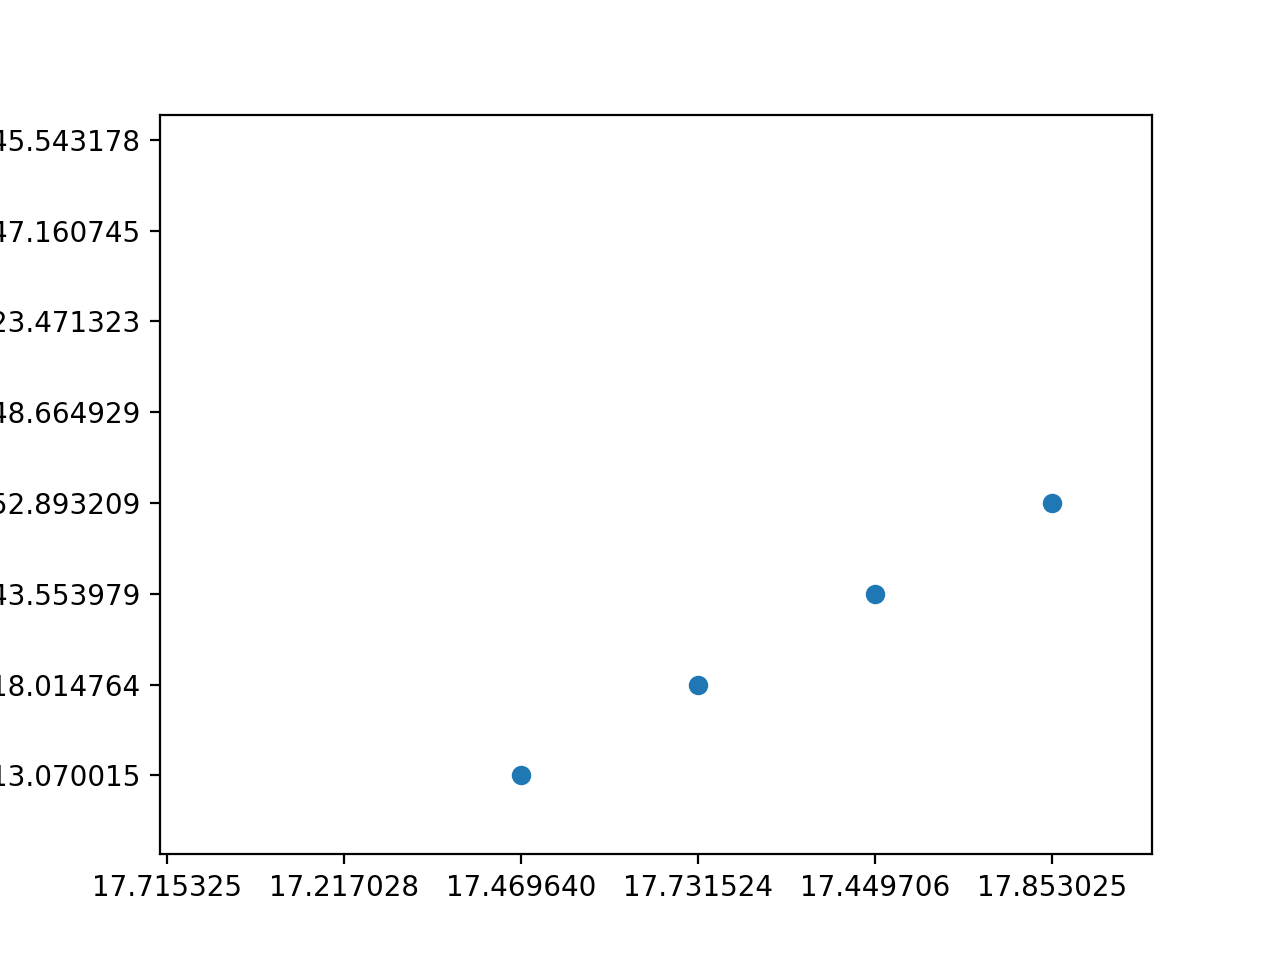

In [26]:
%matplotlib notebook
import seaborn as sns
#sns.pairplot(res[['RA','DEC']])
import matplotlib.pyplot as plt
plt.scatter(res['RA'],res['DEC'])
plt.show()

In [155]:
grad = grades()
mag = mags()
file = open("data/170000-2407.3.lc","r")
text = file.readlines()
df = parser(text)
file.close()

Select GRADE, usage "A,B,..." with valid options A,B,C,D: A
Select MAG, usage MAG_2,MAG_0,MAG_1,MAG_3,MAG_4 like 0,0,1,0,0 for only MAG_1 with full weight: 0,0,1,0,0


In [166]:
#mag = ('0','0','1','0','0')
res = grade_filter(df,grad,mag)
stat = get_statistics(res[0],res[1])
col= ["ASAS NAME","RA","DEC","Q1","C1","Q2","C2"]
row= []
ra,dec= get_ra_dec(df)
row.append([0,ra,dec,stat[0],stat[1],stat[2],stat[3]])
df2 = pd.DataFrame(row,columns=col)
df2

,ASAS NAME,RA,DEC,Q1,C1,Q2,C2
0,0,17.000018,-24.121600,1.496925,0.007691,5.845684,0.101599


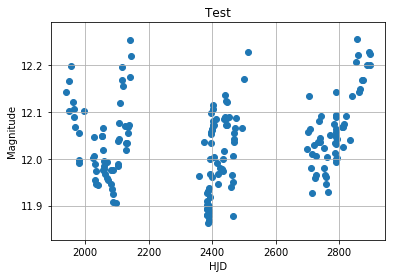

In [128]:
import matplotlib
import matplotlib.pyplot as plt

def Sort(tup): 
    # reverse = True (Sorts in Descending order) 
    # key is set to sort using float elements 
    # lambda has been used 
    return(sorted(tup, key = lambda x: float(x[0]), reverse = True)) 
res = Sort(res)

fig, ax = plt.subplots()
ax.scatter(res[0],res[1])

ax.set(xlabel='HJD', ylabel='Magnitude',
       title='Test')
ax.grid()

fig.savefig("test/test"+str(counter)+".png")
plt.show()


In [85]:
preproc


(array([1958.89688, 2031.72434, 2054.68488, 2059.71026, 2087.60202,
        2093.531  , 2102.55559, 2104.57737, 2106.57625, 2109.56902,
        2115.52918, 2116.54167, 2117.53827, 2124.51342, 2125.53898,
        2128.51786, 2130.51013, 2131.53874, 2135.49777, 2137.50336,
        2142.52274, 2144.48212, 2830.74059, 2140.48528, 2151.50195,
        2433.63175, 1933.87525, 1936.88243, 1940.86015, 1947.84863,
        1949.85893, 1953.82451, 1954.84146, 1955.84672, 1961.85266,
        1963.83983, 1965.83068, 1967.83283, 1977.76244, 1979.7854 ,
        1980.79611, 1981.80661, 1982.77693, 2026.75416, 2027.74897,
        2030.73449, 2031.74927, 2032.73189, 2033.72383, 2037.69451,
        2040.78455, 2052.68706, 2053.70974, 2054.69195, 2055.67867,
        2057.68244, 2058.67483, 2061.68047, 2067.71274, 2068.65619,
        2069.65428, 2070.64461, 2080.55571, 2081.62407, 2082.64195,
        2083.62851, 2085.61255, 2086.62069, 2087.61155, 2088.61031,
        2095.63638, 2096.59201, 2102.56514, 2103

In [3]:
grades = input('Select GRADE, usage "A,B,..." with valid options A,B,C,D: ')
mags = input('Select MAG, usage MAG_2,MAG_0,MAG_1,MAG_3,MAG_4 like 0,0,1,0,0 for only MAG_1 with full weight:')
file = open("data/170010-5102.2.lc","r")
text = file.readlines()
df = parser(text)
mask = df['GRADE'].isin(tuple(grades.split(","))).all(1)
res = df[mask]
res

Select GRADE, usage "A,B,..." with valid options A,B,C,D: A,B,C
Select MAG, usage MAG_2,MAG_0,MAG_1,MAG_3,MAG_4 like 0,0,1,0,0 for only MAG_1 with full weight:0,1,1,0,0


,HJD,MAG_2,MAG_0,MAG_1,MAG_3,MAG_4,MER_2,MER_0,MER_1,MER_3,MER_4,GRADE,FRAME,RA,DEC
0,1958.89688,10.764,10.808,10.761,10.723,10.686,0.031,0.057,0.042,0.034,0.034,A,10316.0,17.002834 17:00:10.2,-51.036509 -51:02:11.4
1,2031.72434,10.949,11.042,10.988,10.866,10.779,0.026,0.054,0.028,0.029,0.035,A,18050.0,17.002834 17:00:10.2,-51.036509 -51:02:11.4
3,2054.68488,10.875,10.980,10.917,10.813,10.725,0.030,0.070,0.034,0.034,0.040,A,20267.0,17.002834 17:00:10.2,-51.036509 -51:02:11.4
4,2059.71026,10.821,10.904,10.888,10.777,10.769,0.036,0.077,0.042,0.038,0.043,B,21310.0,17.002834 17:00:10.2,-51.036509 -51:02:11.4
5,2087.60202,10.725,10.756,10.732,10.674,10.608,0.027,0.065,0.032,0.031,0.036,A,24246.0,17.002834 17:00:10.2,-51.036509 -51:02:11.4
6,2093.53100,10.707,10.668,10.746,10.663,10.610,0.027,0.066,0.032,0.030,0.037,A,24667.0,17.002834 17:00:10.2,-51.036509 -51:02:11.4
7,2102.55559,10.716,10.745,10.751,10.652,10.606,0.024,0.058,0.029,0.027,0.032,A,25627.0,17.002834 17:00:10.2,-51.036509 -51:02:11.4
8,2104.57737,10.691,10.733,10.696,10.623,10.576,0.030,0.057,0.034,0.031,0.035,A,25985.0,17.002834 17:00:10.2,-51.036509 -51:02:11.4
9,2106.57625,10.733,10.800,10.745,10.685,10.617,0.020,0.041,0.022,0.023,0.029,A,26409.0,17.002834 17:00:10.2,-51.036509 -51:02:11.4
10,2109.56902,10.686,10.731,10.716,10.610,10.562,0.023,0.057,0.030,0.026,0.030,A,26578.0,17.002834 17:00:10.2,-51.036509 -51:02:11.4


In [131]:
counter = 0
counter+=1
counter+=1
counter

2

In [106]:
MAG = []
count = 1
for i in mags:
    if i==1:
        

,MAG_0,MAG_2
0,10.808,10.764
1,11.042,10.949
3,10.980,10.875
4,10.904,10.821
5,10.756,10.725
6,10.668,10.707
7,10.745,10.716
8,10.733,10.691
9,10.800,10.733
10,10.731,10.686


In [36]:
mags = input('Select MAG, usage MAG_2,MAG_0,MAG_1,MAG_3,MAG_4 like 0,0,1,0,0 for only MAG_1 with full weight:')

Select MAG, usage MAG_2,MAG_0,MAG_1,MAG_3,MAG_4 like 0,0,1,0,0 for only MAG_1 with full weight:1,0,2,0,0


In [9]:
data = np.array([6,2,4,5])
error_limit = 3
np.where((data >= error_limit))

(array([0, 2, 3]),)